# Image Captioning with LSTMs
In the previous exercise you implemented a vanilla RNN and applied it to image captioning. In this notebook you will implement the LSTM update rule and use it for image captioning.

In [1]:
# As usual, a bit of setup
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cv.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cv.rnn_layers import *
from cv.captioning_solver import CaptioningSolver
from cv.classifiers.rnn import CaptioningRNN
from cv.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cv.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Load MS-COCO data
As in the previous notebook, we will use the Microsoft COCO dataset for captioning.

In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  /home/adrianb3/dev/ms_cv/assignment3/cv/datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


# LSTM
If you read recent papers, you'll see that many people use a variant on the vanilla RNN called Long-Short Term Memory (LSTM) RNNs. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradients caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task. 

In the code, we assume that data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$, and will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$

# LSTM: step forward
Implement the forward pass for a single timestep of an LSTM in the `lstm_step_forward` function in the file `cv/rnn_layers.py`. This should be similar to the `rnn_step_forward` function that you implemented above, but using the LSTM update rule instead.

Once you are done, run the following to perform a simple test of your implementation. You should see errors on the order of `e-8` or less.

In [3]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  5.7054131967097955e-09
next_c error:  5.8143123088804145e-09


# LSTM: step backward
Implement the backward pass for a single LSTM timestep in the function `lstm_step_backward` in the file `cv/rnn_layers.py`. Once you are done, run the following to perform numeric gradient checking on your implementation. You should see errors on the order of `e-7` or less.

In [4]:
np.random.seed(231)

N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dh error: ', rel_error(dh_num, dh))
print('dc error: ', rel_error(dc_num, dc))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  6.335119419831213e-10
dh error:  3.3963756540159307e-10
dc error:  1.5221723979041107e-10
dWx error:  2.1010960934639614e-09
dWh error:  9.712296180612259e-08
db error:  2.4915214652298706e-10


# LSTM: forward
In the function `lstm_forward` in the file `cv/rnn_layers.py`, implement the `lstm_forward` function to run an LSTM forward on an entire timeseries of data.

When you are done, run the following to check your implementation. You should see an error on the order of `e-7` or less.

In [5]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print('h error: ', rel_error(expected_h, h))

h error:  8.610537452106624e-08


# LSTM: backward
Implement the backward pass for an LSTM over an entire timeseries of data in the function `lstm_backward` in the file `cv/rnn_layers.py`. When you are done, run the following to perform numeric gradient checking on your implementation. You should see errors on the order of `e-8` or less. (For `dWh`, it's fine if your error is on the order of `e-6` or less).

In [6]:
from cv.rnn_layers import lstm_forward, lstm_backward
np.random.seed(231)

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)

fx = lambda x: lstm_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: lstm_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: lstm_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: lstm_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  7.004465572957536e-09
dh0 error:  1.5042762239853887e-09
dWx error:  3.2262954818402093e-09
dWh error:  2.698465344563659e-06
db error:  8.23664986941212e-10


# INLINE QUESTION

Recall that in an LSTM the input gate $i$, forget gate $f$, and output gate $o$ are all outputs of a sigmoid function. Why don't we use the ReLU activation function instead of sigmoid to compute these values? Explain.

**Your Answer:** 



# LSTM captioning model

Now that you have implemented an LSTM, update the implementation of the `loss` method of the `CaptioningRNN` class in the file `cv/classifiers/rnn.py` to handle the case where `self.cell_type` is `lstm`. This should require adding less than 10 lines of code.

Once you have done so, run the following to check your implementation. You should see a difference on the order of `e-10` or less.

In [7]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
  model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.824459354432264
expected loss:  9.82445935443
difference:  2.2648549702353193e-12


# Overfit LSTM captioning model
Run the following to overfit an LSTM captioning model on the same small dataset as we used for the RNN previously. You should see a final loss less than 0.5.

base dir  /home/adrianb3/dev/ms_cv/assignment3/cv/datasets/coco_captioning
(Iteration 1 / 100) loss: 79.551150
(Iteration 11 / 100) loss: 43.829101
(Iteration 21 / 100) loss: 30.062619
(Iteration 31 / 100) loss: 14.020163
(Iteration 41 / 100) loss: 6.005545
(Iteration 51 / 100) loss: 1.848214
(Iteration 61 / 100) loss: 0.636644
(Iteration 71 / 100) loss: 0.283085
(Iteration 81 / 100) loss: 0.234823
(Iteration 91 / 100) loss: 0.123913


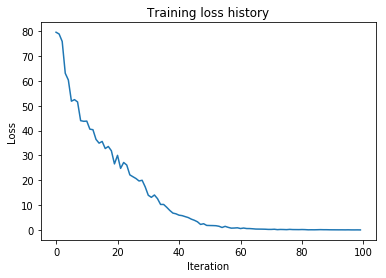

In [8]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

Print final training loss. You should see a final loss of less than 0.5.

In [ ]:
print('Final loss: ', small_lstm_solver.loss_history[-1])

# LSTM test-time sampling
Modify the `sample` method of the `CaptioningRNN` class to handle the case where `self.cell_type` is `lstm`. This should take fewer than 10 lines of code.

When you are done run the following to sample from your overfit LSTM model on some training and validation set samples. As with the RNN, training results should be very good, and validation results probably won't make a lot of sense (because we're overfitting).

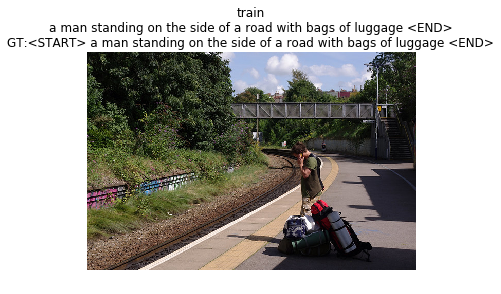

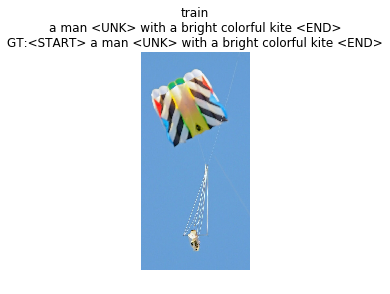

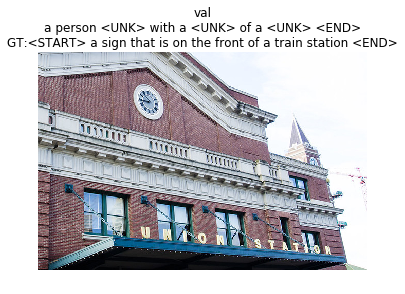

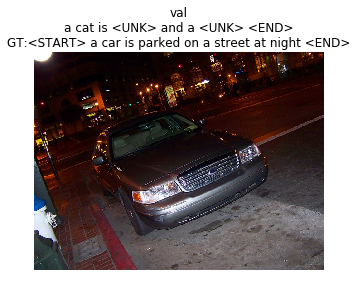

In [9]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()